# MIDS UC Berkeley - Machine Learning at Scale
## DATSCIW261 ASSIGNMENT #7  

[James Gray](https://github.com/jamesgray007)   
jamesgray@ischool.berkeley.edu   
Time of Initial Submission: 08:15 PM US Central, Sunday, July 10, 2016  
Time of **Resubmission**:  
W261-1, Spring 2016  
Week 7 Homework

In [2]:
# This is code that will apply to the entire workbook

# reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
# this will render matplotlib charts inside the notebook
%matplotlib inline

# Numpy and plotting imports
import numpy as np
import pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creation of Amazon EMR Cluster and S3 Bucket Info

This code will create an EMR cluster using the settings in .mrjob.conf file on my local MacBook Pro.

runners:
  emr:
    ec2_key_pair: w261   
    ec2_key_pair_file: ~/.aws/w261.pem   
    ssh_tunnel: true   
    aws_region: us-east-1   
    ec2_core_instance_type: m3.xlarge   
    ec2_master_instance_type: m3.xlarge   
    num_ec2_core_instances: 3  


### S3 Bucket = jamesgray-w261/

This is the bucket where the input data files are stored in addition to the MapReduce outputs

In [33]:
# create EMR Cluster
!mrjob create-cluster --max-hours-idle 1

Using configs in /Users/jamesgray/.mrjob.conf
Using s3://mrjob-5a4b4386e2160458/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /var/folders/ld/9wpyxfw13t7_pdv_0b8958x40000gn/T/no_script.jamesgray.20160711.010235.910038
Copying local files to s3://mrjob-5a4b4386e2160458/tmp/no_script.jamesgray.20160711.010235.910038/files/...
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
j-2ZNYC647FVZWV


# General Description

In this assignment you will explore networks and develop MRJob code for finding shortest path graph distances. To build up to large data you will develop your code on some very simple, toy networks. After this you will take your developed code forward and modify it and apply it to two larger datasets (performing EDA along the way).

### == Undirected toy network dataset ==

In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

### ==Directed toy network dataset==

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

# HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!




## HW7.0 MR Job Code for Computing Shortest Path for Toy Network Graph

In [4]:
%%writefile shortestpath.py
# code for computing shortest path for toy network graph
from __future__ import division
from mrjob.job import MRJob
from mrjob.job import MRStep
import re
import ast

WORD_RE = re.compile(r"[\w']+")
 
class MRShortestPath(MRJob):

    # set configuration options for MRJob
    def configure_options(self):
        super(MRShortestPath, self).configure_options()
        self.add_passthrough_option('--start', default='1', type=str)
        self.add_passthrough_option('--end', default='4', type=str)
        self.add_passthrough_option('--statuspath', default='', type=str)
        self.add_passthrough_option('--iteration', default='1', type=str)
        self.add_passthrough_option('--jobtype', default='local', type=str)

        
    def mapper(self, node, line):
        if self.options.iteration=='1':
            line = line.strip('\n')
            data = line.split("\t")
            status = 'U' # set everything to unvisited for the initial iteration

            # This is the first inialization (from original graph file)
            # there are only 2 elements, the node and adjacency list
            if(len(data) == 2): 
                nid = data[0]
                N = ast.literal_eval(data[1])

                # if our node is the start node , initialize the start
                # distance at source = 0.0
                if nid == self.options.start:
                    ds = 0.0
                    status = 'V'
                    path=[nid]
                else: 
                    # if this is not the start node, initialize distance to inf and path to empty list
                    ds = float("inf")
                    path=[]

                # yield the root node , (distance, graph structure, status, "Visited", and path (as a list))
                yield  nid, (ds, N, status,path)

                # nor each of the nodes in the adjacency list, 
                # we expand frontier with starting distance.
                for m,d in N.iteritems():
                    #new distance is going to be from root node  + dist              
                    newdist = d+ds
                    new_path=path[:]
                    new_path.append(m)
                    if newdist < float("inf"):
                        status = 'Q'

                    yield m, (newdist, None, status,new_path)
                
        # from Iteration 1 onwards we'll land here...more data items to track
        else:
            if self.options.jobtype=='local':
                inf=float("inf") 
                line = line.strip('\n')
                nid,data=eval(line)
            
            if self.options.jobtype=='emr':
                Infinity=float('inf') 
                line = line.strip('\n')
                nid,data=line.split('\t')
                nid=eval(nid)
                data=eval(data)
            
            
            dist=data[0]
            N = data[1] # adjacency list - graph to use for next iter
            status = data[2] #status - U, Q, V
            path=data[3] #list of previously visited nodes
            
              
            #If a node is in the frontier, expand it
            if status=='Q':
                #Emit original node
                yield  nid, (dist, N, 'V',path)
                
                #Emit linked nodes
                for m,d in N.iteritems():
                    newdist=d+dist
                    new_path=path[:]
                    new_path.append(m)
                    yield m, (newdist, None, 'Q', new_path)
            
            #If it's not in the frontier, pass it through unchanged
            else:        
                yield  nid, (dist, N, status,path)
                    
                    
    def reducer_init(self):
        
        self.finished=0
        self.shortest_path=[]
        self.min_dist=0
            
    def reducer(self, node, distances):
        adjList = {} #adjacency list - to be compiled below
        sdist = float("inf") #this is the shortest distance we've seen to the node so far
        stati = [] #list of all statuses we've encountered for this node
        spath=[] #shortest path we've found to the node so far
        for dist in distances:
            node_dist,list_of_links,temp_status,path=dist[:]

            # Extract the original graph structure from the node that has it
            if list_of_links:
                adjList = list_of_links
            
            stati.append(temp_status)
            
            #If we find a record of a visited node, we can move on
            if temp_status == 'V':
                sdist=node_dist
                spath = path
                break
                       
            # If we find a shorter distance to a node, update our knowledge of it
            if node_dist < sdist:
                sdist = node_dist
                spath=path
                if node not in spath:
                    spath.append(node)
            
        #Check the current state of the node
        if 'V' in stati:
            status='V'
            #Have we hit our destination node?
            if node==self.options.end :
                self.shortest_path=spath
                self.finished=1
                self.min_dist=sdist
        elif 'Q' in stati:
            status='Q'
        else:
            status='U'
            
        yield node, (sdist, adjList, status, spath)
        
    def steps(self):
        return [MRStep( 
                        mapper=self.mapper
                        ,reducer_init=self.reducer_init
                        ,reducer=self.reducer
                      )]
    
if __name__ == '__main__':
    MRShortestPath.run()

Overwriting shortestpath.py


## HW7.0 - Undirected Toy Graph (Run MR Job Locally)

In [5]:
%reload_ext autoreload
%autoreload 2
from shortestpath import MRShortestPath
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='undirected_toy'
start_node='1'
end_node='4'


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case

while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRShortestPath(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
DONE
Shortest path from 1 to 4 is 2 steps long:
The path is:  ['1', '2', '4']


## HW7.0 - Directed Toy Graph (Run Locally)

In [6]:
## HW7 - Directed Toy Example, running locally
%reload_ext autoreload
%autoreload 2
from shortestpath import MRShortestPath
from __future__ import division
                                       

iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}


#### TEST VERSION #####
input_dir_prefix='directed_toy'
start_node='1'
end_node='5'

#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case

while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRShortestPath(args=[input_directory, 
                         #'--file=start_end.txt',
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        #'--statuspath',status_path,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True 
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 1 to 5 is 3 steps long:
The path is:  ['1', '2', '4', '5']


# Main dataset 1: NLTK synonyms

In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

* s3://ucb-mids-mls-networks/synNet/synNet.txt
* s3://ucb-mids-mls-networks/synNet/indices.txt
* On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

Sample records:

1	{'2': 1, '3': 1, '4': 1}   
2	{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}   
3	{'1': 1, '2': 1, '4': 1}   
4	{'1': 1, '2': 1, '3': 1, '311': 1}   
5	{'6': 1}   


in indexed form, and indices.txt contains a lookup list

(word) \t (index)

Sample records:

A	1  
As	2  
a	3  
as	4  
AB	5  
abdominal	6  
AD	7  
ad	8  
advertising	9  
AIDS	10  


of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

# HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data. Consider plotting the degree distribution (does it follow a power law?) and determine some of the key features, like:

* number of nodes, 
* number links,
* or the average degree (i.e., the average number of links per node),etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). Once you have gotten you code to run locally, deploy it on AWS as a systems test in preparation for our next dataset (which will require AWS).

### Power Law

The Power Law is often described as the 80/20 rule such as ranking of popularity where a few items are responsible for the majority of popular items and there is a long tail with small popularity.

![graph](img/graph.png)

## HW7.1 - MRJob for EDA of Key Features (# nodes, links, links/node)

This is the MRJob code to calculate summary statistics about the network graph.  Here we will compute the number of nodes, links and links/nodes.

In [7]:
%%writefile eda.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
from operator import itemgetter
import re
import ast

class MRnltkeda(MRJob):
            
    def mapper(self, _, line):
        """ Generate mapper output records with values as (1,node_degree) to calculate # of nodes, links"""
        line = line.strip('\n')
        data = line.split("\t")
        nodeid = data[0] # node
        N = eval(data[1]) # dict as node links
        node_degree = len(N)
        yield _,(1,node_degree)

        
    def reducer(self, nodeid, line):
        """Aggregate node counts and degree counts"""
        nodes=0
        edges=0
        for record in line:
            nodes+=record[0]
            edges+=record[1]    
        yield None, (nodes,edges)
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    MRnltkeda.run()

Overwriting eda.py


## HW 7.1 - MRJob Driver (Local Execution)

In [8]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from eda import MRnltkeda

mr_job = MRnltkeda(args=['synNet.txt','--no-strict-protocols'])
nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total # of network nodes = {}".format(nodes)   
print "Total # of network edges = {}".format(edges)   
print "Average # of edges/node = {}".format(edges/nodes)

Total # of network nodes = 8271
Total # of network edges = 61134
Average # of edges/node = 7.39136742836


## HW7.1 - Calculate and Plot Degree of Distribution for the Network

This code will calculate the counts of nodes by the number of connections and we will see if it follows the power law

In [9]:
%%writefile power.py

from mrjob.job import MRJob
from mrjob.job import MRStep
import csv
from operator import itemgetter
import re
import ast

class MRDegreeDist(MRJob):
            
    def mapper(self, _, line):
        """The goal of the mapper is to generate outputs of:
        Key: The node's degree (with padded zeros)
        Value: 1
        """
        line = line.strip('\n')
        data = line.split("\t")
        #nodeid = data[0]
        N = eval(data[1])
        if N:
            node_degree = len(N)
        else:
            node_degree=0
        # Padding the degrees with leading zeros gives us results in order nicely
        yield '{0:010d}'.format(node_degree), 1

    def reducer(self, degree, count):
        """Aggregate pairs returned by the mapper"""
        total_nodes=sum([i for i in count])  
        yield degree, total_nodes
    
    def steps(self):
        return [MRStep(  mapper=self.mapper
                    ,reducer=self.reducer
                )
            ]
                
if __name__ == '__main__':
    MRDegreeDist.run()

Overwriting power.py


In [10]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from power import MRDegreeDist

input_dir_prefix='synNet'

mr_job = MRDegreeDist(args=['{0}.txt'.format(input_dir_prefix),'--no-strict-protocols'])
nodes=0
edges=0
with open ('{0}_degree_distribution.txt'.format(input_dir_prefix),'w') as f:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            #Write results to a file so we can plot them more easily
            f.writelines(line)

print "Done"

Done


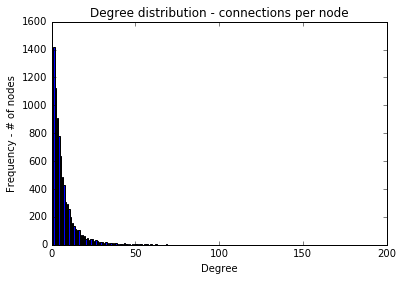

In [11]:
x=[]
y=[]
with open ('{0}_degree_distribution.txt'.format(input_dir_prefix),'r') as f:
    for line in f.readlines():
        data=line.strip('\n').split('\t')
        degree=int(eval(data[0]))
        count=int(data[1])
        x.append(degree)
        y.append(count)

plt.bar(x,y)
plt.xlabel('Degree')
plt.ylabel('Frequency - # of nodes')
plt.title('Degree distribution - connections per node')
plt.show()

## HW7.1 - Run EDA on Amazon EMR

In [13]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from eda import MRnltkeda

input_dir_prefix='synNet'
input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
cluster='j-2TVDH7F520X1Y'

#EMR VERSION
mr_job = MRnltkeda(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://jamesgray-w261/'+input_dir_prefix+'output',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total Nodes = {}".format(nodes)   
print "Total Edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)
                

Total Nodes = 8271
Total Edges = 61134
Average Edges/Node = 7.39136742836


# HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

NOTE: ====  Dataset 2 English Wikipedia hyperlink network.data ====
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

on S3 at  s3://ucb-mids-mls-networks/wikipedia/
-- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt # Graph
-- s3://ucb-mids-mls-networks/wikipedia/indices.txt               # Page titles and page Ids

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.


For the remainder of this assignment you will explore the English Wikipedia hyperlink network.
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

## HW 7.2 - NLTK Shortest Path (Local Execution)

In [14]:
%reload_ext autoreload
%autoreload 2
from shortestpath import MRShortestPath
from __future__ import division
                                       
iterate = 1
stop = False
last_total_dist = float("inf")
start_node = ''
end_node = ''
end_sdist = float("inf")
path = {}

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'  # we are going to start "walking" at this node
end_node='536' # this is the final node we are looking to walk to


#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case

while(not stop and iterate <= 20):
    
    output_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate))
    if iterate==1:
        input_directory=input_dir_prefix+'.txt'
    else:
        input_directory=input_dir_prefix+'Output{0}.txt'.format(str(iterate-1))

    #LOCAL VERSION - IN WHICH WE WRITE RESULTS TO A FILE
    mr_job = MRShortestPath(args=[input_directory, 
                         '--no-strict-protocols',
                        '--start',start_node,
                        '--end',end_node,
                        '--iteration',str(iterate)])
    
    
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        
        #Stream output locally
        with open(output_directory, 'w+') as f:
            for line in runner.stream_output():
                nid,distances =  mr_job.parse_output_line(line)
                dist,adjlist,status,path  = distances
                f.write(str(mr_job.parse_output_line(line))+'\n')
                if nid==end_node and status=='V':
                    print "DONE"
                    print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                    print "The path is: ",path
                    stop=True
                if nid==end_node:
                    break

        #just in case this thing does not stop..
        iterate += 1   


Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '1426', '1668', '536']


## HW 7.2 - NLTK Shortest Path - Run on Amazon EMR

In [21]:
# NLTK example, running in EMR
%reload_ext autoreload
%autoreload 2
from shortestpath import MRShortestPath
from __future__ import division

iterate = 1
stop = False

# This is the Amazon EMR cluster ID that gets created at the top of the notebook
cluster='j-2TVDH7F520X1Y'

#### NLTK VERSION #####
input_dir_prefix='synNet'
start_node='7827'
end_node='536'

#### RUN THE JOBS #####
#The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):

    if iterate==1:
        input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
    else:
        input_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRShortestPath(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            if nid==end_node and status=='V':
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(start_node,end_node,str(len(path)-1))
                print "The path is: ",path
                stop=True
            if nid==end_node:
                break
            
        #just in case this thing does not stop..
        iterate += 1   

Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
DONE
Shortest path from 7827 to 536 is 3 steps long:
The path is:  ['7827', '4655', '631', '536']


# HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.


## HW 7.3 - EDA on Wikipedia data using 7.1 Code

In this section we will use the code from HW7.1 and explore the Wikipedia data using AWS.  In regard to scaling well, this code took a lot longer to process than 7.1

In [23]:
%reload_ext autoreload
%autoreload 2
from __future__ import division
from eda import MRnltkeda

input_dir_prefix='all-pages-indexed-out'
input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
cluster='j-2TVDH7F520X1Y'

#EMR VERSION
mr_job = MRnltkeda(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://jamesgray-w261/wiki_eda_output',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

nodes=0
edges=0
with mr_job.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        _,count =  mr_job.parse_output_line(line)
        nodes+=count[0]
        edges+=count[1]

print "Total # of network nodes = {}".format(nodes)   
print "Total # of network edges = {}".format(edges)   
print "Average Edges/Node = {}".format(edges/nodes)

Total # of network nodes = 5781290
Total # of network edges = 142114057
Average Edges/Node = 24.5817208616


In [24]:
# Calculating degree distribution on full Wikipedia dataset
%reload_ext autoreload
%autoreload 2
from __future__ import division
from eda import MRnltkeda

input_dir_prefix='all-pages-indexed-out'
input_directory='s3://jamesgray-w261/'+input_dir_prefix+'.txt'
cluster='j-2TVDH7F520X1Y'

#EMR VERSION
mr_job = MRnltkeda(args=['-r', 'emr',
                     input_directory,
                     '--no-strict-protocols',
                     '--output-dir','s3://jamesgray-w261/wiki_dist_output',
                     '--no-output',
                     '--emr-job-flow-id', cluster,
                    ])

with open ('{0}_degree_distribution_EMR.txt'.format(input_dir_prefix),'w') as f:
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            #Write results to a file so we can plot them more easily
            f.writelines(line)

print "Done"

Done


In [25]:
# plot distribution from EMR
x=[]
y=[]
with open ('{0}_degree_distribution_EMR.txt'.format(input_dir_prefix),'r') as f:
    for line in f.readlines():
        data=line.strip('\n').split('\t')
        degree=int(eval(data[0]))
        count=int(data[1])
        x.append(degree)
        y.append(count)

plt.bar(x,y)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

NameError: name 'null' is not defined

# HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.

In [30]:
# Here we will load the index into memory.
word_dict={}
node_dict={}
with open('./wiki/indices.txt') as f:
    for line in f.readlines():
        word,node_id,_,_=line.strip().split('\t')
        node_dict[node_id]=word #Enables us to find words by ID
        word_dict[word]=node_id #Enables us to find IDs by word

In [31]:
# HW 7.4 - Full Wikipedia data, running in EMR
%reload_ext autoreload
%autoreload 2
from shortestpath import MRShortestPath
from __future__ import division

iterate = 1
stop = False

# Amazon EMR Cluster ID
cluster='j-2TVDH7F520X1Y'

# Wikipedia index
input_dir_prefix='wiki'
start_node='6176135'  # we are starting the "walk" from Ireland
end_node='13466359' # we are ending the "walk" at UC Berkeley

# The second condition is insurance to make sure we stop after a finite number of cycles...just in case
while(not stop and iterate <= 10):
    
    if iterate==1:
        input_directory='s3://jamesgray-w261/all-pages-indexed-out.txt'
    else:
        input_directory='s3://jamesgray-w261/'+input_dir_prefix+'Output{0}/'.format(str(iterate-1))
    
    #EMR VERSION
    mr_job = MRShortestPath(args=['-r', 
                         'emr',
                         input_directory,
                         '--start',start_node,
                         '--end',end_node,
                         '--no-strict-protocols',
                         '--output-dir','s3://jamesgray-w261/'+input_dir_prefix+'Output{0}'.format(str(iterate)),
                         '--no-output',
                         '--jobtype','emr',
                         '--emr-job-flow-id', cluster,
                         '--iteration',str(iterate)
                        ])

 
    with mr_job.make_runner() as runner: 
        runner.run()
        print "Iteration : {0}".format(iterate)
        for line in runner.stream_output():
            nid,distances =  mr_job.parse_output_line(line)
            dist,adjlist,status,path  = distances
            
            #If we've hit our stopping condition, print results and finish up
            if nid==end_node and status=='V':
                word_path=[node_dict[word]+' ('+word+')' for word in path]
                print "DONE"
                print "Shortest path from {0} to {1} is {2} steps long:".format(node_dict[start_node],node_dict[end_node],str(len(path)-1))
                print "The path is: \n",' ->\n'.join(word_path)
                stop=True
            if nid==end_node:
                break
        # increment the iteration we are on
        iterate += 1   

Iteration : 1
Iteration : 2
Iteration : 3
DONE
Shortest path from Ireland to University of California, Berkeley is 2 steps long:
The path is: 
Ireland (6176135) ->
Seamus Heaney (11607791) ->
University of California, Berkeley (13466359)


# HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

### HW7.5 -  Thoughts on Largest distance problem

The following two articles provide some insight to the longest path problem
* https://en.wikipedia.org/wiki/Longest_path_problem
* http://www.geeksforgeeks.org/find-longest-path-directed-acyclic-graph/

Conceptually I would expect a similar iteration framework to the shortest path problem but perhaps it would need to run longer to ensure it processed the entire graph network.  The articles above state that the longest distance problem cannot be solved in polynomial time unlike the shortest path problem so computationally it would follow that its more intensive and requires a longer processing cycle.



# HW 7.5.1: 

**_Can we utilize combiners in the HW 7 to perform the shortest path implementation?_**

My guess is that we could likely use a combiner to reduce network traffic by resolving and netting out nodes that have been already visited so they are not passed to the reducer for processing.  

**_Does order inversion help with the HW 7 shortest path implementation?_**

I asssume this refers to reducing the processing load on the reducer by using order inversion. While I am not completely sure, perhaps processing could be reduced if the order aligned with the sequencing of the nodes for the path (meaning the ordering were the nodes in the frontier).



# HW 7.5.2: OPTIONAL

Implement combiners in the context of HW 7.5 and contrast the performance of this implementation versus the implementation with  no combiners. Please report the cluster configuration and runtimes in tabular format for both experiments and comment on your findings.

# HW 7.6: Computational exercise: Largest single-source network distances (optional)

Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.